## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

## Reading, preprocessing, and splitting the dataset into the training and test set

For data preprocessing, we standardize features by removing the mean and scaling to unit variance.

In [2]:
#importing the dataset
dataset = pd.read_excel('sEMG_dataset.xlsx')
X = dataset.iloc[:,0:6].values
y = dataset.iloc[:,6].values

#Feature scaling
X = np.transpose(np.array([(X[:,i]-np.mean(X[:,i]))/(np.std(X[:,i])) for i in range(X.shape[1])]))

#splitting the dataset into the training set and test set
test_size = 0.25

ds = np.concatenate((X, y[:,np.newaxis]), axis=1)

ds_shuffle = np.random.permutation(ds)
X_val = ds_shuffle[:math.ceil(test_size*ds_shuffle.shape[0]),0:6]
y_val = ds_shuffle[:math.ceil(test_size*ds_shuffle.shape[0]),6]    
X_train = ds_shuffle[math.ceil(test_size*ds_shuffle.shape[0]):,0:6]
y_train = ds_shuffle[math.ceil(test_size*ds_shuffle.shape[0]):,6]


## Training (parameter calculation)

1. In the training process, we must calculate some parameters based on training data. The first step is calculating each class probability. 
2. In order to do so, we separate the training data belonging to class1 from those belonging to class0. The number of training data points belonging to class1 divided by the total number of training data points indicates class1 probability. Similarly, class0 probability is calculated. 
3. Gaussian Naïve Bayes training algorithm assumes that each data conditional probability follows a Gaussian distribution that for the purpose of training the algorithm each of both mean and variance parameters must be calculated.(Another assumption is about the conditional independence of data given classes.)

In [3]:
##separating the data points with the class0 from class1

inx1 = [i for (i, val) in enumerate(y_train) if val == 1]
X_train_class1 = np.empty((len(inx1),6))
k=0
for j in inx1 :
    X_train_class1[k,:] = X_train[j,:]
    k = k+1

inx0 = [i for (i, val) in enumerate(y_train) if val == 0]
X_train_class0 = np.empty((len(inx0),6))
k=0
for j in inx0 :
    X_train_class0[k,:] = X_train[j,:]
    k = k+1

##parameter calculation

num_features = X_train.shape[1]
num_training_examples = X_train.shape[0]

mu_i0 = [np.mean(X_train_class0[:,i]) for i in range(num_features)]
mu_i1 = [np.mean(X_train_class1[:,i]) for i in range(num_features)]
sigma2_i0 = [np.var(X_train_class0[:,i]) for i in range(num_features)]
sigma2_i1 = [np.var(X_train_class1[:,i]) for i in range(num_features)]

p_class0 = X_train_class0.shape[0] / num_training_examples
p_class1 = X_train_class1.shape[0] / num_training_examples

## Making predictions

In this section, the GNB model will make predictions on the test set based on the parameters calculated in the previous step and by using the Naive Bayes classification rule. 
We are interested in the most probable value of class label(Y), so we have the Naive Bayes classification rule which is based on the Bayes rule and a set of conditional independence assumptions:

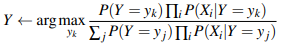

which simplifies to the following (because the denominator does not depend on yk).

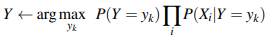

In [4]:
#prediction
y_pred = np.empty(y_val.shape[0])
for i in range(X_val.shape[0]):
    p0=1
    p1=1
    for k in range(X_val.shape[1]):
        p0 = p0*((math.exp(((X_val[i][k]-mu_i0[k])**2)/
                           (-2 * sigma2_i0[k])))/(math.sqrt(2*np.pi*sigma2_i0[k])))
        p1 = p1*((math.exp(((X_val[i][k]-mu_i1[k])**2)/
                           (-2 * sigma2_i1[k])))/(math.sqrt(2*np.pi*sigma2_i1[k])))
        
    p0 = p_class0*p0
    p1 = p_class1*p1
    if p1>p0:
        y_pred[i]=1
    else:
        y_pred[i]=0

## Evalustion

In [5]:
#Making the Confusion Matrix
cm = np.zeros((2,2))
for i in range(y_pred.shape[0]):
    if y_pred[i]==0 and y_val[i]==0:
        cm[0][0]+=1
    if y_pred[i]==1 and y_val[i]==0:
        cm[0][1]+=1    
    if y_pred[i]==0 and y_val[i]==1:
        cm[1][0]+=1
    if y_pred[i]==1 and y_val[i]==1:
        cm[1][1]+=1
    
accuracy = (cm[0][0]+cm[1][1])/y_pred.shape[0]
print('confusion_matrix:', cm)
print('accuracy:', accuracy)    

confusion_matrix: [[240. 271.]
 [107. 403.]]
accuracy: 0.6297747306562194
